## Example 1: Marker Pose Estimation

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
from realsense_wrapper import RealsenseAPI
import time

import fairotag as frt

DATA_DIR = "data/1_marker_pose_estimation"
NUM_CALIB_SAMPLES = 5
MARKER_LENGTH = 0.04

Collect sample images using real sense

In [17]:
rs = RealsenseAPI()

num_cameras = rs.get_num_cameras()
assert num_cameras == 1, "Camera not found OR multiple cameras?"
intrinsics = rs.get_intrinsics()[0]


Connecting to RealSense cameras (1 found) ...
Connected to camera 1 (817612070939).


In [ ]:
imgs = []
for i in range(NUM_CALIB_SAMPLES):
    imgs.append(rs.get_rgbd())
    time.sleep(2.0)


In [ ]:

rs.stop()

In [6]:
imgs[0].shape

(1, 480, 640, 4)

In [32]:
type(intrinsics)

pyrealsense2.pyrealsense2.intrinsics

In this example we will identify markers and estimate their respective poses in the following image taken from a phone.

In [34]:
rgb_images = []
for img in imgs:
    # rgb_images.append(cv2.cvtColor(img.squeeze()[:,:,:3], cv2.COLOR_BGR2RGB))
    rgb_images.append(img.squeeze()[:,:,:3])

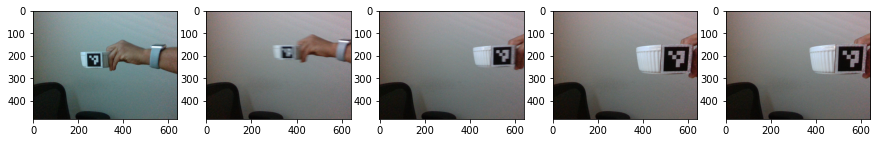

In [35]:
# img = cv2.imread(os.path.join(DATA_DIR, "test_5x5.jpg"))
fig = plt.figure(figsize=(15, 3))
for idx, img in enumerate(rgb_images):
    plt.subplot(1, len(rgb_images), idx+1)
    plt.imshow(img)


A `CameraModule` contains metadata of a specific camera and exposes functionalities for detecting markers seen from the camera.

Camera intrinsics parameters can be directly assigned using `CameraModule.set_intrinsics`, or manually calibrated with a Charuco board. 
As shown in the following example, manual calibration can be performed by printing the provided Charuco board pdf on a letter paper (8.5" x 11"), then taking photos of the calibration board from different angles. 
(Note that `calibrate_camera` is underperforming right now and it is advised to directly set the intrinsics from the spec sheet of the camera)

A camera module will be able to identify all markers within an image, but will only be able to estimate the poses of those with registered sizes. In this example we will only register 3 of the markers out of the 6 markers in the image.

In [37]:
# Initialize module
c = frt.CameraModule()

# Calibrate camera
# (Images of the Charuco board taken at different angles are labeled as "charuco_<number>.jpg".)
# imgs = []
# for i in range(NUM_CALIB_SAMPLES):
#     filename = os.path.join(DATA_DIR, f"charuco_{i + 1}.jpg")
#     img_calib = cv2.imread(filename)
#     imgs.append(img_calib)

c.set_intrinsics(intrinsics)
# c.calibrate_camera(rgb_images)

# Register markers
c.register_marker_size(0, MARKER_LENGTH)
# c.register_marker_size(3, MARKER_LENGTH)
# c.register_marker_size(4, MARKER_LENGTH)

`CameraModule.detect_markers` takes an image and returns the detected markers as a list of `MarkerInfo`.

`MarkerInfo` - a NamedTuple containing the following fields:
- `id`: Marker ID
- `corner`: Image coordinates of the four corners of the marker 
- `length`: Marker length (`None` if marker not registered)
- `pose`: Transformation of the marker in the camera frame expressed using [sophus](https://pypi.org/project/sophuspy/).SE3  (`None` if marker not registered)

In [40]:
markers = c.detect_markers(rgb_images[-1])
print(markers)

error: OpenCV(4.4.0) /tmp/pip-req-build-b_zf9wbm/opencv_contrib/modules/aruco/src/aruco.cpp:107: error: (-215:Assertion failed) _in.type() == CV_8UC1 || _in.type() == CV_8UC3 in function '_convertToGrey'


Identified markers and their estimated poses can also be rendered on the input image for visualization and debug purposes.

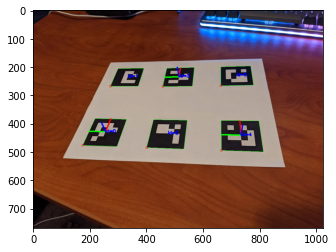

In [5]:
img_rend = c.render_markers(img, markers=markers)
plt.imshow(cv2.cvtColor(img_rend, cv2.COLOR_BGR2RGB))